# 0. Quick Intro on Jupyter and Python

Let's first take a look at the editor "Jupyter Notebook" that we are using today.

## The Jupyter Notebook: 
* An open source web application 
* To create and share documents that contain live code, equations, visualizations, and text
* Ships with the IPython kernel, supports over 100 other kernels (R, Julia, etc.)


### Running Cells:

* A Notebook’s cell defaults to using code whenever you first create one
* Uses the kernel that you chose when you started your Notebook
* Started with Python 3 as kernel, one can write Python code in the code cells
* To execute a cell, you can just select the cell and click the Run button (keyboard press Shift+Enter)
* The primary cell types are the Code and Markdown cell types

### More Functionalities:

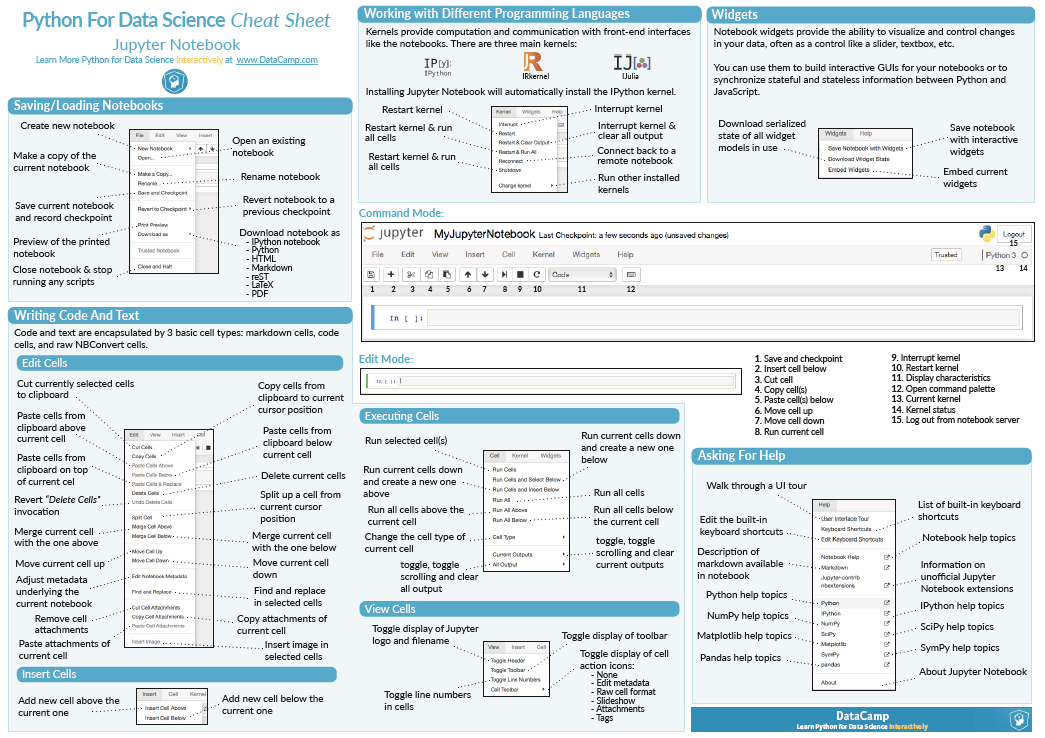

## Useful References:
* [Jupyter Cheatsheet](https://www.edureka.co/blog/wp-content/uploads/2018/10/Jupyter_Notebook_CheatSheet_Edureka.pdf)
* [Python Cheatsheet](https://perso.limsi.fr/pointal/_media/python:cours:mementopython3-english.pdf)
* [Markdown Cheatsheet](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet)

# 1. A Quick Running Example of Time Series Forecasting


### Dataset - [Walmart Store Sales Forecasting](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data)

- Historical sales data for 45 Walmart stores located in different regions. 
- Each store contains a number of departments, and we are interested in predicting the department-wide sales for each store.
- Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. 
- We have formatted the original data in a csv file for easier manipulation.

### Pandas 
- pandas is an open source library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.
- Python has long been great for data munging and preparation, but less so for data analysis and modeling. pandas helps fill this gap, enabling you to carry out your entire data analysis workflow in Python without having to switch to a more domain specific language like R.
- Tools for reading and writing data between in-memory data structures and different formats: CSV and text files, Microsoft Excel, SQL databases.
- Aggregating or transforming data with a powerful group by engine allowing split-apply-combine operations on data sets.
- Time series-functionality: date range generation and frequency conversion, moving window statistics, moving window linear regressions, date shifting and lagging. Even create domain-specific time offsets and join time series without losing data. https://pandas.pydata.org/pandas-docs/stable/reference/frame.html#time-series-related

#### [Pandas Cheatsheet](https://assets.datacamp.com/blog_assets/PandasPythonForDataScience.pdf)

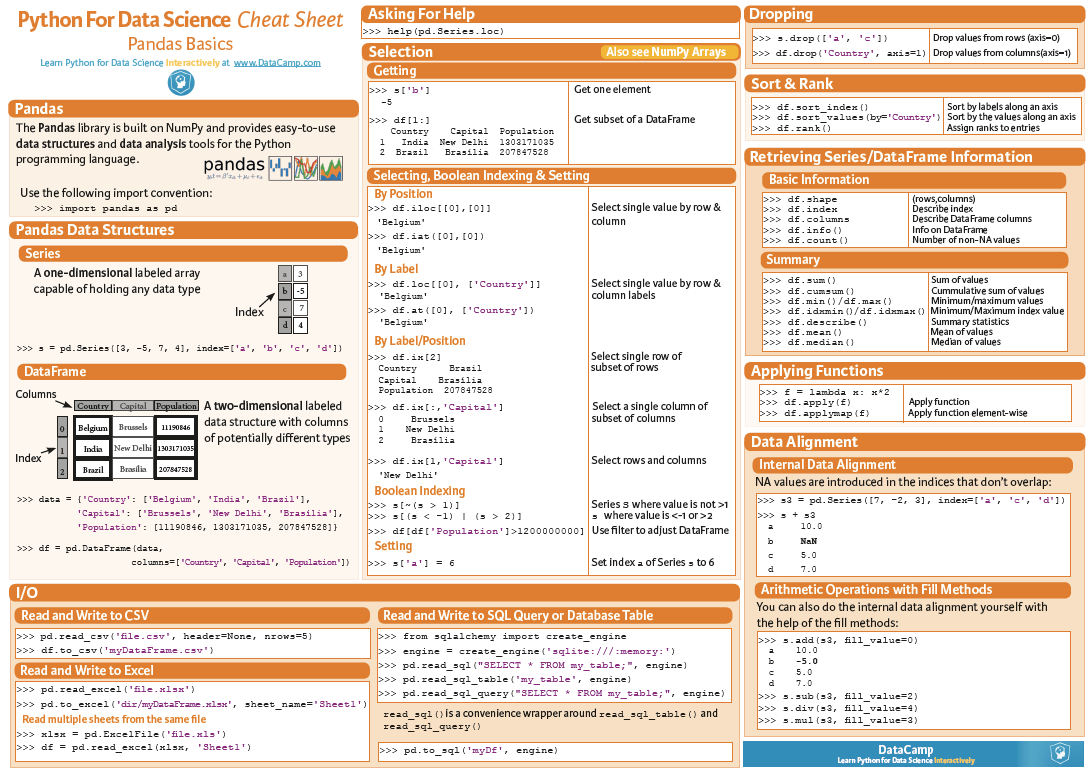


In [ ]:
import pandas as pd

In [ ]:
ts = pd.read_csv('../data/sales_weekly.csv', index_col='ds')
print("Number of rows: " + str(ts.shape[0]) + "; Number of columns: " + str(ts.shape[1]))

In [ ]:
ts.head(5)

## 1.1 Explore the Data with Visulization

- The first thing to do in any data analysis task is to plot the data. 
- It enable us to observe patterns, unusual observations, changes over time, and relationships between variables. 
- The features that are seen in plots of the data must then be incorporated, as much as possible, into the forecasting methods to be used. Just as the type of data determines what forecasting method to use, it also determines what graphs are appropriate. 

[Choosing a Python Visualization Tool](https://pbpython.com/python-vis-flowchart.html)

In [ ]:
from plotly import tools
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode()

In [ ]:
ts['ds'] = ts.index
ts['ds'] = pd.to_datetime(ts['ds'])
ts = ts.set_index('ds')

In [ ]:
data_10_10 = go.Scatter(x=ts.index, y=ts['10_10'], name='10_10')
data_10_13 = go.Scatter(x=ts.index, y=ts['10_13'], name='10_13')

fig = tools.make_subplots(rows=2, cols=1)
fig.append_trace(data_10_10, 1, 1)
fig.append_trace(data_10_13, 2, 1)

fig['layout'].update(height=400, width=900, title='Data Visualization')
py.iplot(fig)

## 1.2 Get Better Understanding of the Data Using Basic Stats 

- Essentials: type, unique values, missing values, most frequent values, etc.
- Quantile statistics like minimum value, Q1, median, Q3, maximum, range, etc.
- Descriptive statistics like mean, mode, standard deviation, etc.

In [ ]:
import ts_profiling

In [ ]:
ts_profiling.ProfileReport(ts[['10_10','10_13']], bins=50, check_correlation=False, check_recoded=False)

### Correlation between series

- Correlation: It is common to compute correlation coefficients to measure the strength of the relationship between two variables. 

- The value of  always lies between -1 and 1 with negative values indicating a negative relationship and positive values indicating a positive relationship. The correlation coefficient only measures the strength of the linear relationship.

In [ ]:
corr = ts.corr('pearson')
print("Number of rows: " + str(corr.shape[0]) + "; Number of columns: " + str(corr.shape[1]))

In [ ]:
corr.head(10)

In [ ]:
trace1 = go.Scatter(x = ts['10_17'], y = ts['10_14'], mode = 'markers')
trace2 = go.Scatter(x = ts['10_12'], y = ts['10_18'], mode = 'markers')
fig = tools.make_subplots(rows=1, cols=2)
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig['layout'].update(height=400, width=900, title='Scatter Plot')
py.iplot(fig)

## 1.3 Trend, Seasonality & Residual

##### \[Definition from https://otexts.com/fpp2/ a textbook by Prof. Rob J Hyndman and Prof. George Athanasopoulos\]

#### Trend: 
* A trend exists when there is a long-term increase or decrease in the data. 
* It does not have to be linear. Sometimes we will refer to a trend as “changing direction”, when it might go from an increasing trend to a decreasing trend.

#### Seasonal: 

* A seasonal pattern occurs when a time series is affected by seasonal factors such as the time of the year or the day of the week. Seasonality is always of a fixed and known frequency. 

#### Additive vs. Multiplicative
- The additive decomposition is the most appropriate if the magnitude of the seasonal fluctuations, or the variation around the trend-cycle, does not vary with the level of the time series. When the variation in the seasonal pattern, or the variation around the trend-cycle, appears to be proportional to the level of the time series, then a multiplicative decomposition is more appropriate. Multiplicative decompositions are common with economic time series.

- An alternative to using a multiplicative decomposition is to first transform the data until the variation in the series appears to be stable over time, then use an additive decomposition. When a log transformation has been used, this is equivalent to using a multiplicative decomposition.

In [ ]:
import statsmodels.api as sm

#### Time Series analysis (TSA) https://www.statsmodels.org/dev/tsa.html#

statsmodels.tsa contains model classes and functions that are useful for time series analysis. 

In [ ]:
decomposition = sm.tsa.seasonal_decompose(ts['10_10'], model='additive', freq=13)

In [ ]:
data0 = go.Scatter(x=ts['10_10'].index, y=ts['10_10'].values, name='Data')
data1 = go.Scatter(x=decomposition.trend.index, y=decomposition.trend.values, name='Trend')
data2 = go.Scatter(x=decomposition.seasonal.index, y=decomposition.seasonal.values, name='Seasonality')
data3 = go.Scatter(x=decomposition.resid.index, y=decomposition.resid.values, name='Residual')

fig = tools.make_subplots(rows=4, cols=1)
fig.append_trace(data0, 1, 1)
fig.append_trace(data1, 2, 1)
fig.append_trace(data2, 3, 1)
fig.append_trace(data3, 4, 1)

fig['layout'].update(height=500, width=900, title='Classic MA Decomposation')
py.iplot(fig)

### Comments on classical decomposition

While classical decomposition is still widely used, it has some issues as summarised below:

* The classical decomposition methods assume that the seasonal component repeats, and are unable to capture seasonal changes over time.
* The estimate of the trend-cycle is unavailable for the first few and last few observations.
* The classical method is not robust to outliner values.

### STL Method (Seasonal and Trend decomposition using Loess)

Loess regression is a nonparametric technique that uses local weighted regression to fit a smooth curve through points in a scatter plot. Loess curves are can reveal trends and cycles in data that might be difficult to model with a parametric curve. 

STL has several advantages over the classical decomposition method:

* STL will handle any type of seasonality, not only monthly and quarterly data.

* The seasonal component is allowed to change over time.

* It can be robust to outliers, so that occasional unusual observations will not affect the estimates of the trend-cycle and seasonal components. They will, however, affect the remainder component.

On the other hand, STL has some disadvantages:
* STL does not handle trading day or calendar variation automatically, and it only provides facilities for additive decompositions.
* It is possible to obtain a multiplicative decomposition by first taking logs of the data, then back-transforming the components. 


In [ ]:
from stldecompose import decompose

In [ ]:
stl = decompose(ts['10_10'], period=13)

In [ ]:
data0 = go.Scatter(x=ts['10_10'].index, y=ts['10_10'].values, name='Data')
data1 = go.Scatter(x=stl.trend.index, y=stl.trend.values, name='Trend')
data2 = go.Scatter(x=stl.seasonal.index, y=stl.seasonal.values, name='Seasonality')
data3 = go.Scatter(x=stl.resid.index, y=stl.resid.values, name='Residual')

fig = tools.make_subplots(rows=4, cols=1)
fig.append_trace(data0, 1, 1)
fig.append_trace(data1, 2, 1)
fig.append_trace(data2, 3, 1)
fig.append_trace(data3, 4, 1)

fig['layout'].update(height=600, width=900, title='STL Decomposation')
py.iplot(fig)

### Residuals

The “residuals” in a time series model are what is left over after fitting a model. For many (but not all) time series models, the residuals are equal to the difference between the observations and the corresponding fitted values. Residuals are useful in checking whether a model has adequately captured the information in the data. A good forecasting method will yield residuals with the following properties:

- The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.

- The residuals have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.

Any forecasting method that does not satisfy these properties can be improved. It is possible to have several different forecasting methods for the same data set, all of which satisfy these properties. Checking these properties is important in order to see whether a method is using all of the available information, but it is not a good way to select a forecasting method.

If either of these properties is not satisfied, then the forecasting method can be modified to give better forecasts. Adjusting for bias is easy: if the residuals have mean then simply add to all forecasts and the bias problem is solved. Fixing the correlation problem is harder.

In [ ]:
stl.resid.values.mean()

In [ ]:
kpss_stat, p_value, lags, crit = sm.tsa.stattools.kpss(stl.resid.values)
print("kpss: " + str(kpss_stat) + "; p_value: " + str(p_value) +"; lags: " + str(lags) +"; crit: " + str(crit))

## 1.4 Using STL to Forecast

To forecast a decomposed time series, we forecast the seasonal component, and the seasonally adjusted component separately. It is usually assumed that the seasonal component is unchanging, or changing extremely slowly, so it is forecast by simply taking the last year of the estimated component. 

- For naïve forecasts, we simply set all forecasts to be the value of the last observation. 
- Seasonal naïve is useful for highly seasonal data. We set each forecast to be equal to the last observed value from the same season of the year.
- Drift is a variation on the naïve method is to allow the forecasts to increase or decrease over time, where the amount of change over time (called the drift) is set to be the average change seen in the historical data.

In [ ]:
from stldecompose import forecast
from stldecompose.forecast_funcs import (naive,
                                         drift, 
                                         seasonal_naive)

In [ ]:
train_ts = ts['10_10'][0:-39]
validate_ts = ts['10_10'][-39:]

In [ ]:
stl = decompose(train_ts, period=13)
fcast_n = forecast(stl, steps=39, fc_func=naive, seasonal=True)
fcast_d = forecast(stl, steps=39, fc_func=drift, seasonal=True)

In [ ]:
layout = go.Layout(autosize=False, width=900, height=300)
data = [go.Scatter(x=fcast_n.index, y=fcast_n['naive+seasonal'], name='forecast_stl_naive'),
       go.Scatter(x=validate_ts.index, y=validate_ts, name='real')]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [ ]:
layout = go.Layout(autosize=False, width=900, height=300)
data = [go.Scatter(x=fcast_d.index, y=fcast_d['drift+seasonal'], name='forecast_stl_drift'),
       go.Scatter(x=validate_ts.index, y=validate_ts, name='real')]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## 1.5 Measure Forecast Accurancy

A few commonly used measurement of accurancy/error:

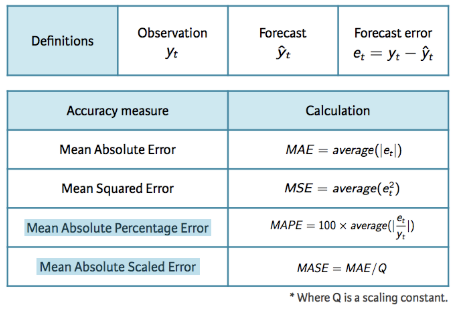

\[Image from https://uc-r.github.io/ts_benchmarking#accuracy \]

In [ ]:
import numpy as np
def mape(predictions, actuals):
    """Mean absolute percentage error"""
    return (np.absolute((predictions - actuals) / actuals)).mean()

In [ ]:
mape(fcast_n['naive+seasonal'],validate_ts)

In [ ]:
mape(fcast_d['drift+seasonal'],validate_ts)

## 1.6 Forecast Workflow

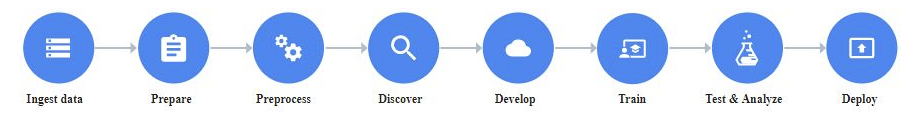

## 2. Using Prophet to Forecast

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects ([FB Prophet Github Page](https://facebook.github.io/prophet/))


- It works best with time series that have strong seasonal effects and several seasons of historical data. 
- Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.
- The Prophet procedure includes many possibilities for users to tweak and adjust forecasts. One can use human-interpretable parameters to improve your forecast by adding your domain knowledge.

Prophet consider four major factors: (1) Growth; (2) Seasonality; (3) Holiday; (4) Residual

- Growth can be modeled by considering: (1) capacity (i.e., max and min of trend); (2) change points; (3) Additive or Multiplicative.
- Prophet uses a linear model for its forecast. When forecasting growth, there is usually some maximum achievable point: total market size, total population size, etc. This is called the carrying capacity, and the forecast should saturate at this point.
- Time series may frequently have abrupt changes in their trajectories. By default, Prophet will automatically detect these changepoints and will allow the trend to adapt appropriately.



In [ ]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

In [ ]:
ts_prophet = ts
ts_prophet['ds']=ts_prophet.index
train_ts=ts_prophet[['ds','10_10']][0:-39]
train_ts.columns = ['ds','y']
train_ts.index.names=['index']

In [ ]:
model = Prophet(yearly_seasonality=True)
model.fit(train_ts)

In [ ]:
future = model.make_future_dataframe(39, freq='W-FRI', include_history=False)
forecast = model.predict(future)

In [ ]:
forecast.head(5)

In [ ]:
layout = go.Layout(autosize=False, width=1000, height=300)
data = [go.Scatter(x=validate_ts.index, y=validate_ts, name='real'),
       go.Scatter(x=validate_ts.index, y=forecast['yhat'], name='forecast'),
       go.Scatter(x=validate_ts.index, y=forecast['yhat_lower'], name='forecast_lower'),
       go.Scatter(x=validate_ts.index, y=forecast['yhat_upper'], name='forecast_upper')]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [ ]:
mape(forecast['yhat'].values,validate_ts.values)

### Predication Interval

A prediction interval gives an interval within which we expect y to lie with a specified probability. For example, assuming that the forecast errors are normally distributed. There are three sources of uncertainty in the forecast: 
- uncertainty in the trend; 
- uncertainty in the seasonality estimates;
- additional observation noise.

In [ ]:
fig = model.plot_components(forecast)

In [ ]:
from fbprophet.diagnostics import cross_validation

In [ ]:
df_cv = cross_validation(model, initial='364 days', horizon = '273 days', period='28 days')

In [ ]:
df_cv.head(10)

In [ ]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape',rolling_window=0.1)

## Quick Recap